In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as spopt
import scipy.fftpack as spfft
import cvxpy as cvx
import cv2

In [2]:
def dct2(x):
    return spfft.dct(spfft.dct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

def idct2(x):
    return spfft.idct(spfft.idct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

In [3]:
# read original image and downsize for speed
x = cv2.imread('imgs/monalisa_pix.jpg', 0)
ny,nx = x.shape
print(f"The shape of x: ({ny}, {nx})")

The shape of x: (52, 40)


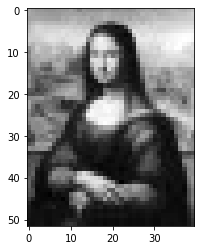

In [4]:
# show original image
plt.imshow(x, cmap='gray')
plt.show()

In [5]:
# extract small sample of signal
sample_rate = 0.5
k = round(nx * ny * sample_rate)
flt = np.random.choice(nx * ny, k, replace=False)        # filter for y
y = x.T.flat[flt]
print(f"The size of y: {y.shape}")

The size of y: (1040,)


In [6]:
# generate Theta = C @ psai from filter
Theta = np.kron(
    spfft.idct(np.identity(nx), norm='ortho', axis=0),
    spfft.idct(np.identity(ny), norm='ortho', axis=0)
    )[flt, :]
print(Theta.shape)

(1040, 2080)


In [7]:
# do L1 optimization
vx = cvx.Variable(nx * ny)
objective = cvx.Minimize(cvx.norm(vx, 1))
constraints = [Theta @ vx == y]
prob = cvx.Problem(objective, constraints)
result = prob.solve(verbose=True)
Xat2 = np.array(vx.value).squeeze()

                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Feb 09 03:20:32 PM: Your problem has 2080 variables, 1 constraints, and 0 parameters.
(CVXPY) Feb 09 03:20:32 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 09 03:20:32 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 09 03:20:32 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 09 03:20:32 PM: Compiling problem (target solver=ECOS).
(CVXPY) Feb 09 03:20:32 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing 

sparsity (0-elems) : 0.4985576923076923


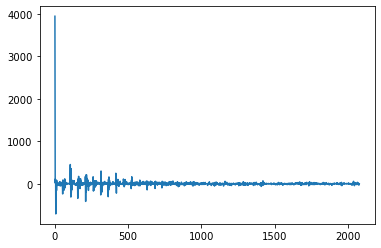

In [8]:
plt.plot(Xat2)
for i, m in enumerate(Xat2):
    if abs(m) < 1e-6: Xat2[i] = 0
print(f"sparsity (0-elems) : {len(Xat2[Xat2 == 0]) / len(Xat2)}")

(52, 40)


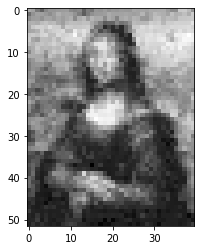

In [9]:
# reconstruct signal
Xat = Xat2.reshape(nx, ny).T
Xa = idct2(Xat)
print(Xa.shape)

plt.imshow(Xa, cmap='gray')
plt.show()

In [10]:
# compare the similarity between two images

import sewar

def metrics(origin, recover):
    # smaller means more similar
    print("MSE: ",      sewar.mse(origin,recover))
    print("RMSE: ",     sewar.rmse(origin, recover))
    # bigger means more similar
    print("PSNR: ",     sewar.psnr(origin, recover))
    print("SSIM: ",     sewar.ssim(origin, recover))
    print("UQI: ",      sewar.uqi(origin, recover))

metrics(x, Xa.astype(np.uint8))

MSE:  567.9548076923077
RMSE:  23.831802443212467
PSNR:  20.587665807038775
SSIM:  (0.8625330255009257, 0.8633391648945331)
UQI:  0.951116158807713
